In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss

masked_cmap = matplotlib.cm.bwr
masked_cmap.set_bad('black', 0.5)

import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style("darkgrid")

# import models in ../scripts
import sys
sys.path.append("../scripts/")
from models import SIREN
from datasets import OOIDASDataset

/home/niyiyu/anaconda3/envs/seisml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## load data

In [2]:
DR_PATH = f"/fd1/yiyu_data/OOI/OOI-training-15min-demean-15-29-XMIN25000-XMAX40000.npz"
TRAIN_DATA = np.load(DR_PATH)['raw'][::8,::8]
TRAIN_DATA -= TRAIN_DATA.min()
TRAIN_DATA /= abs(TRAIN_DATA).max()

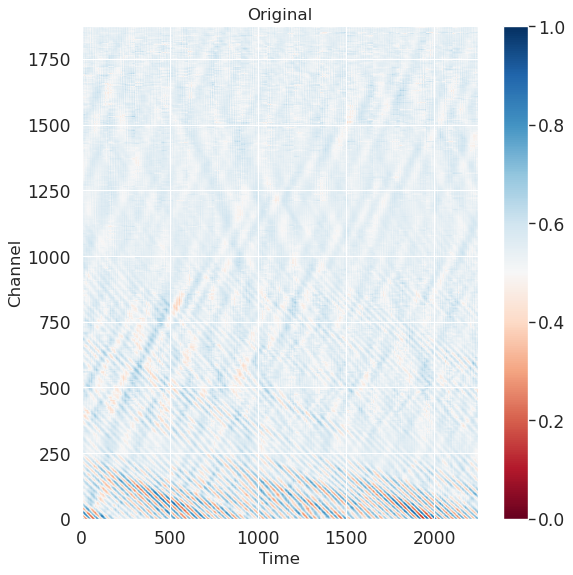

In [3]:
fig = plt.figure(figsize = (8, 8), dpi = 80)
plt.imshow(TRAIN_DATA[:, :], cmap = 'RdBu', aspect = 'auto', origin='lower')
plt.title("Original", fontsize = 15)
plt.ylabel("Channel", fontsize = 15)
plt.xlabel("Time", fontsize = 15)
plt.colorbar()

## preprocessing data and send to data loader

In [4]:
NX, NT = TRAIN_DATA.shape
t, x = np.meshgrid(np.arange(NT), np.arange(NX))
T = t/(NT-1); X = x/(NX-1)

all_data = np.concatenate([T.reshape([-1, 1]), X.reshape([-1, 1]), TRAIN_DATA.reshape([-1, 1])], axis = -1)

print(T.shape, X.shape, all_data.shape)

dataset = OOIDASDataset(all_data[:, :-1], np.expand_dims(all_data[:, -1], axis = -1))
data_loader = DataLoader(dataset, batch_size=1024*16, shuffle=True, num_workers = 4)

(1875, 2250) (1875, 2250) (4218750, 3)


## defind model and initize the weights

In [5]:
device = torch.device('cuda')
n_units = 128
n_layers = 20
n_input = 2
n_output = 1
omega = 30
model = SIREN(n_input = n_input, 
              n_output = n_output, 
              n_layers = n_layers, 
              n_units = n_units, 
              omega = omega)

for name, mod in model.named_parameters():
    if "inputs" in name:     # for input layer
        if 'bias' in name:
            mod.data.uniform_(-1/np.sqrt(n_input), 1/np.sqrt(n_input))
        elif 'weight' in name:
            mod.data.uniform_(-1/2, 1/2)
    else:                    # for hidden layer
        if 'bias' in name: 
            mod.data.uniform_(-1/np.sqrt(n_units), 1/np.sqrt(n_units))
        elif 'weight' in name:
            mod.data.uniform_(-np.sqrt(6/n_units)/omega, np.sqrt(6/n_units)/omega) 
            
model.to(device);

In [17]:
nweights = 0
for name, i in model.named_parameters():
    nweights += len(i.data.flatten())
print(f"have total {nweights}")

have total 330753


## training

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
loss_fn = MSELoss()

In [9]:
nepoch = 40
train_losses = []
for t in range(nepoch):
    print(f"Epoch {t+1}")
    ## train
    model.train()
    train_loss = 0
    
    
    for batch_id, batch in tqdm(enumerate(data_loader), total = len(data_loader)):
        pred = model(batch[0].to(device))
        loss = loss_fn(pred, batch[1].to(device))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    
    train_loss /= len(data_loader)
    train_losses.append(train_loss)
    print("train loss %.8f"  % (train_loss))

Epoch 1


100%|██████████| 258/258 [00:08<00:00, 29.13it/s]

train loss 0.00256169
Epoch 2



100%|██████████| 258/258 [00:08<00:00, 31.55it/s]

train loss 0.00236805
Epoch 3



100%|██████████| 258/258 [00:07<00:00, 33.39it/s]

train loss 0.00218024
Epoch 4



100%|██████████| 258/258 [00:07<00:00, 33.19it/s]

train loss 0.00181072
Epoch 5



100%|██████████| 258/258 [00:08<00:00, 32.18it/s]

train loss 0.00147350
Epoch 6



100%|██████████| 258/258 [00:08<00:00, 32.06it/s]

train loss 0.00130306
Epoch 7



100%|██████████| 258/258 [00:07<00:00, 33.01it/s]

train loss 0.00120151
Epoch 8



100%|██████████| 258/258 [00:07<00:00, 32.54it/s]

train loss 0.00114951
Epoch 9



100%|██████████| 258/258 [00:08<00:00, 31.73it/s]

train loss 0.00110037
Epoch 10



100%|██████████| 258/258 [00:08<00:00, 31.22it/s]

train loss 0.00106478
Epoch 11



100%|██████████| 258/258 [00:07<00:00, 32.30it/s]

train loss 0.00104455
Epoch 12



100%|██████████| 258/258 [00:07<00:00, 32.48it/s]

train loss 0.00103162
Epoch 13



100%|██████████| 258/258 [00:08<00:00, 31.16it/s]

train loss 0.00101706
Epoch 14



100%|██████████| 258/258 [00:07<00:00, 32.51it/s]

train loss 0.00101213
Epoch 15



100%|██████████| 258/258 [00:07<00:00, 32.31it/s]

train loss 0.00100632
Epoch 16



100%|██████████| 258/258 [00:07<00:00, 33.08it/s]

train loss 0.00100175
Epoch 17



100%|██████████| 258/258 [00:07<00:00, 33.12it/s]

train loss 0.00099415
Epoch 18



100%|██████████| 258/258 [00:07<00:00, 33.03it/s]

train loss 0.00098923
Epoch 19



100%|██████████| 258/258 [00:07<00:00, 32.86it/s]

train loss 0.00098446
Epoch 20



100%|██████████| 258/258 [00:08<00:00, 31.63it/s]

train loss 0.00098007
Epoch 21



100%|██████████| 258/258 [00:07<00:00, 33.00it/s]

train loss 0.00097448
Epoch 22



100%|██████████| 258/258 [00:07<00:00, 33.73it/s]

train loss 0.00096930
Epoch 23



100%|██████████| 258/258 [00:07<00:00, 33.36it/s]

train loss 0.00096796
Epoch 24



100%|██████████| 258/258 [00:07<00:00, 33.12it/s]

train loss 0.00096736
Epoch 25



100%|██████████| 258/258 [00:08<00:00, 32.20it/s]

train loss 0.00096212
Epoch 26



100%|██████████| 258/258 [00:07<00:00, 32.89it/s]

train loss 0.00096043
Epoch 27



100%|██████████| 258/258 [00:07<00:00, 32.40it/s]

train loss 0.00095206
Epoch 28



100%|██████████| 258/258 [00:07<00:00, 33.15it/s]

train loss 0.00095866
Epoch 29



100%|██████████| 258/258 [00:07<00:00, 32.59it/s]

train loss 0.00095196
Epoch 30



100%|██████████| 258/258 [00:07<00:00, 32.49it/s]

train loss 0.00094362
Epoch 31



100%|██████████| 258/258 [00:07<00:00, 32.68it/s]

train loss 0.00094366
Epoch 32



100%|██████████| 258/258 [00:07<00:00, 32.46it/s]

train loss 0.00094375
Epoch 33



100%|██████████| 258/258 [00:07<00:00, 33.65it/s]

train loss 0.00094045
Epoch 34



100%|██████████| 258/258 [00:07<00:00, 33.98it/s]

train loss 0.00093770
Epoch 35



100%|██████████| 258/258 [00:08<00:00, 31.89it/s]

train loss 0.00093544
Epoch 36



100%|██████████| 258/258 [00:07<00:00, 33.55it/s]

train loss 0.00093314
Epoch 37



100%|██████████| 258/258 [00:07<00:00, 32.40it/s]

train loss 0.00092998
Epoch 38



100%|██████████| 258/258 [00:07<00:00, 33.40it/s]

train loss 0.00092983
Epoch 39



100%|██████████| 258/258 [00:07<00:00, 33.84it/s]

train loss 0.00092241
Epoch 40



100%|██████████| 258/258 [00:07<00:00, 33.88it/s]

train loss 0.00092441


Text(0, 0.5, 'Training loss')

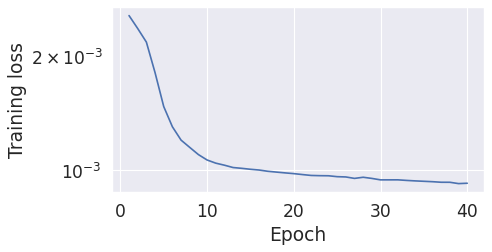

In [10]:
plt.figure(figsize = (6, 3), dpi = 80)
plt.plot(np.arange(1, 40 + 1), train_losses)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Training loss")

In [11]:
all_data_2d = all_data.reshape(NX, NT, 3)[:, :, :2]
predict = np.zeros([NX, NT])

In [12]:
npiece = 5
for i in range(npiece):
    _gpu_predict = model(torch.Tensor(all_data_2d[i*375:(i+1)*375, :, :].reshape(-1, 2)).to(device)).reshape(375, NT)
    predict[i*375:(i+1)*375, :] = _gpu_predict.detach().cpu().numpy()
    torch.cuda.empty_cache()

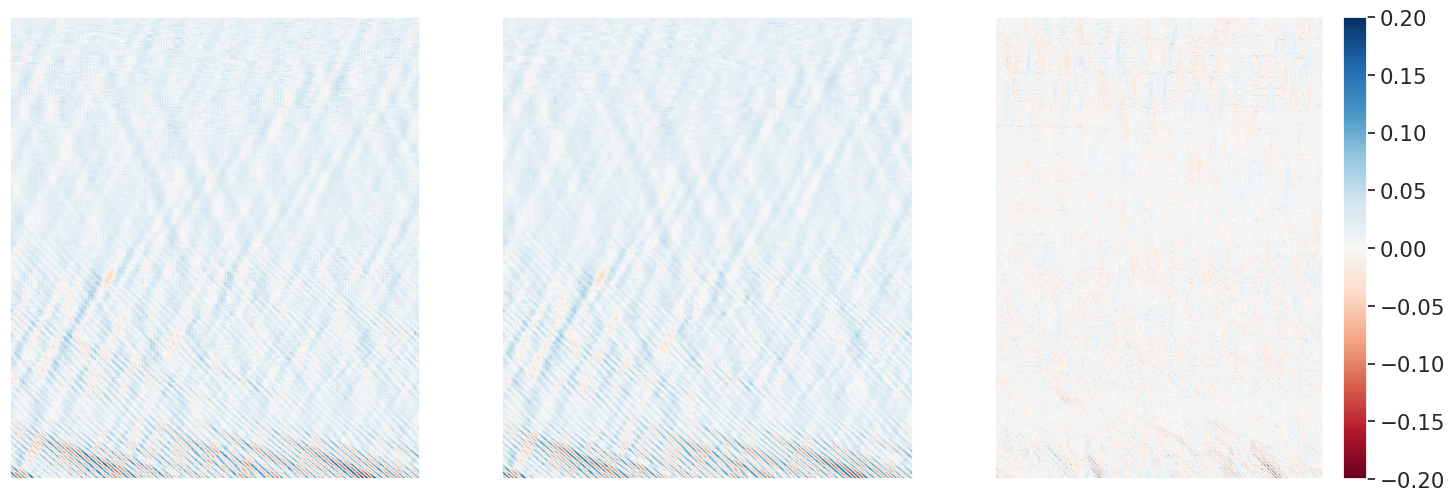

In [18]:
plt.figure(figsize = (18, 6))
plt.subplot(1,3,1)
plt.imshow(TRAIN_DATA, cmap = 'RdBu', aspect = 'auto', origin='lower', 
           vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
plt.xticks([]); plt.yticks([])
# plt.title("original", fontsize = 20)

plt.subplot(1,3,2)
plt.imshow(predict, cmap = 'RdBu', aspect = 'auto', origin='lower', 
           vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
plt.xticks([]); plt.yticks([])
# plt.title("reconstruction", fontsize = 20)

plt.subplot(1,3,3)
plt.imshow(TRAIN_DATA - predict, cmap = 'RdBu', aspect = 'auto', origin='lower', vmin = -0.2, vmax = 0.2)
plt.xticks([]); plt.yticks([])
plt.colorbar()